# Import Libraries

In [ ]:
#import relevant packages
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as stats
%matplotlib inline
from google.colab import files
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import chi2_contingency
from tabulate import tabulate
from scipy.stats import yeojohnson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML
from google.colab import drive
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, classification_report

#Prepare The Notbook

In [ ]:
# Function to create scrollable table within a small window
def create_scrollable_table(data, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto;">'
    html += data.to_html()
    html += '</div>'
    return html

    # Header
    table_html += '<thead><tr>'
    table_html += ''.join(f'<th>{col}</th>' for col in data.columns)
    table_html += '</tr></thead><tbody>'

    # Rows
    for _, row in data.iterrows():
        table_html += '<tr>'
        table_html += ''.join(f'<td>{value}</td>' for value in row)
        table_html += '</tr>'

    table_html += '</tbody></table></div>'
    return table_html

# Import Data

In [ ]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('///content/drive/MyDrive/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [ ]:
head = data.head()

# create_scrollable_table is defined somewhere in your code
html_head = create_scrollable_table(head, 'head', 'Head of the dataset')

# Display the HTML table to show all features
display(HTML(html_head))

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
data = data.drop('customerID', axis=1)

#

# Discovring The Data

In [ ]:
data.shape

(7043, 20)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


we note that TotalCharges it's object but it's type is numeric so we will transform it

In [ ]:
#transform the type of TotalCharges from object to numrical
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')


## Searching About Missing Values

In [ ]:
# Null values in the dataset
null_values = data.isnull().sum()
html_null_values = null_values.to_frame().to_html()

# Show missing values
show_missing_values = data[data.isna().any(axis=1)]
html_show_missing_values = show_missing_values.to_html()

# Display HTML tables
display(HTML("<h2>Null Values in the Dataset</h2>" + html_null_values))
display(HTML("<h2>Show Missing Values of Each Feature</h2>" + html_show_missing_values))


,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


there 11 missing(nan) in TotalCharges

In [ ]:
# handling the missing values with  median
num_missing_values = data['TotalCharges'].isnull().sum()
print(f"missing values in 'TotalCharges befor handling missing': {num_missing_values}")

data.dropna(subset=['TotalCharges'], inplace=True)


num_missing_values = data['TotalCharges'].isnull().sum()
print(f" missing values in 'TotalCharges after handling missing ': {num_missing_values}")

missing values in 'TotalCharges befor handling missing': 11
 missing values in 'TotalCharges after handling missing ': 0


## Searching About Duplicates

In [ ]:
data.duplicated().sum()

22

there aren 22 duplicated so i will reemove them

In [ ]:
data.drop_duplicates(inplace=True)

# EDA and Preprocessing For The Target Variable

## Discovering The Target

In [ ]:
# discribe the target
target_summary_stats = data['Churn'].describe().to_frame().T
print(target_summary_stats)
print('-----------------------------')
# the unique values of target variable
print("Unique Values Of Churn : ", data['Churn'].unique())
print('-----------------------------')
#check from balance
churn_value_counts = data['Churn'].value_counts()
print('The Count Of Each Class : ','\n' ,churn_value_counts)


      count unique top  freq
Churn  7010      2  No  5153
-----------------------------
Unique Values Of Churn :  ['No' 'Yes']
-----------------------------
The Count Of Each Class :  
 No     5153
Yes    1857
Name: Churn, dtype: int64


from the result we note that the target is unbalanced , we have 2 classes(yes,no) ,and  'no' is the most common class

## Target Encoding

In [ ]:

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the 'Churn' column
data['Churn'] = label_encoder.fit_transform(data['Churn'])

# Print the unique values after label encoding
print("Churn ", data['Churn'].unique())

Churn  [0 1]


# EDA and Preprocessing For Numerical Features

In [ ]:
#select the numrical features only and drop target
numerical_features = data.select_dtypes(include=['int64', 'float64']).drop(['Churn'], axis=1)


## Ensure from the data types

In [ ]:
head_numrical=numerical_features.head()

html_head_numrical = create_scrollable_table(head_numrical, 'head_numrical', 'Head of the numrical features')

# Display the HTML
display(HTML(html_head_numrical))

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0,1,29.85,29.85
1,0,34,56.95,1889.50
2,0,2,53.85,108.15
3,0,45,42.30,1840.75
4,0,2,70.70,151.65


In [ ]:
#the unique values of each numrical feature

def display_unique_values(dataframe):
    unique_values_html = ""
    for column in dataframe.columns:
        unique_values = dataframe[column].unique()
        unique_values_html += f"<h4>Unique values for {column}:</h4>"
        unique_values_html += "<div style='max-height: 200px; overflow-y: auto;'>"
        unique_values_html += "<ul>"
        for value in unique_values:
            unique_values_html += f"<li>{value}</li>"
        unique_values_html += "</ul>"
        unique_values_html += "</div>"

    display(HTML(unique_values_html))

# Call the function to display unique values
display_unique_values(numerical_features)

we  note that SeniorCitizen is a categorical feature not a numerical

In [ ]:
#drop SeniorCitizen from the numrical features
numerical_features.drop(['SeniorCitizen'], axis=1, inplace=True)

In [ ]:
# Convert the 'SeniorCitizen' column to object type
data['SeniorCitizen'] = data['SeniorCitizen'].astype(object)

In [ ]:
# Summary statistics for numerical features


# Calculate summary statistics
summary_stats = numerical_features.describe().T

# Create an HTML table
html_numerical = create_scrollable_table(summary_stats, 'numerical_features', 'Summary statistics for numerical features')

# Display the HTML
display(HTML(html_numerical))

,count,mean,std,min,25%,50%,75%,max
tenure,7010.0,32.520399,24.520441,1.00,9.0000,29.000,56.0000,72.00
MonthlyCharges,7010.0,64.888666,30.064769,18.25,35.7500,70.400,89.9000,118.75
TotalCharges,7010.0,2290.353388,2266.820832,18.80,408.3125,1403.875,3807.8375,8684.80


## ANOVA_Test

In [ ]:
target_column = 'Churn'
significance_level = 0.05

# Extract numeric features from the DataFrame
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
data.fillna(numerical_features.median(), inplace=True)
# Create a list to store results
results = []

# Perform ANOVA test for each numeric feature
for column in numeric_features:
    if column != target_column:
        # Perform ANOVA test
        _, p = f_oneway(*[data[data[target_column] == group][column] for group in data[target_column].unique()])

        significance = "Significant" if p < significance_level else "Not Significant"

        results.append([column, p, significance])

# Create a DataFrame from the results
result_df = pd.DataFrame(results, columns=["Feature", "P-value", "Significance"])

# Print the tabulated results
print('ANOVA Test Between The Target Variable (Churn) And the Numeric Features:')
print(tabulate(result_df, headers='keys', tablefmt='pretty', showindex=False))



ANOVA Test Between The Target Variable (Churn) And the Numeric Features:
+----------------+------------------------+--------------+
|    Feature     |        P-value         | Significance |
+----------------+------------------------+--------------+
|     tenure     | 3.093127427396592e-205 | Significant  |
| MonthlyCharges | 2.0218234870891158e-60 | Significant  |
|  TotalCharges  | 3.914665283676891e-63  | Significant  |
+----------------+------------------------+--------------+


All features are significant

## Searching About Outliers

<Figure size 1600x800 with 0 Axes>

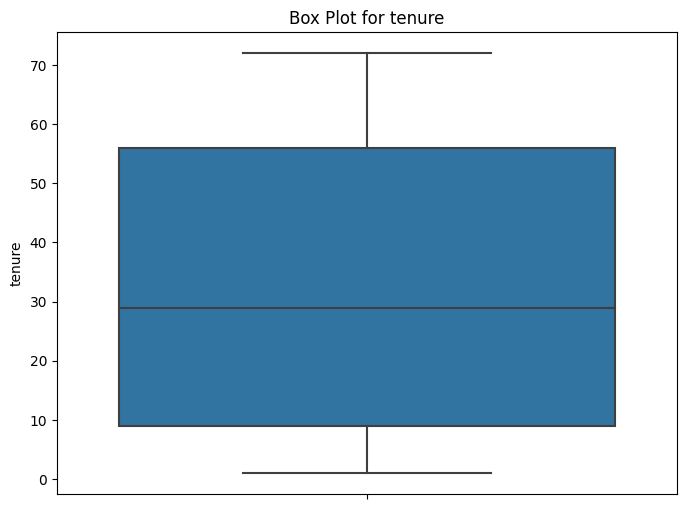

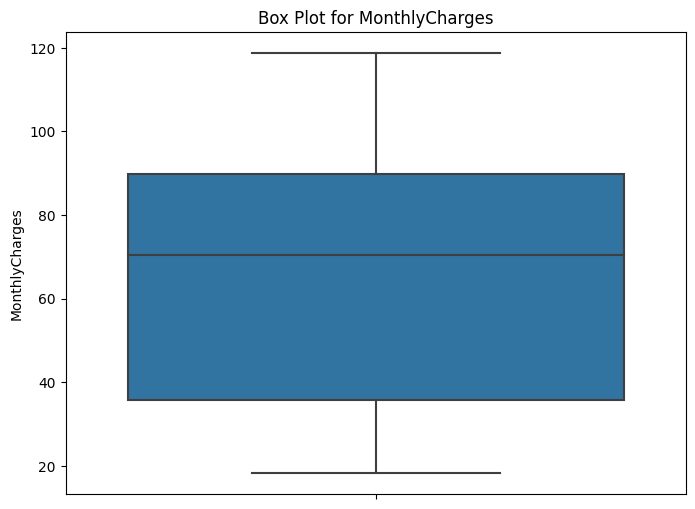

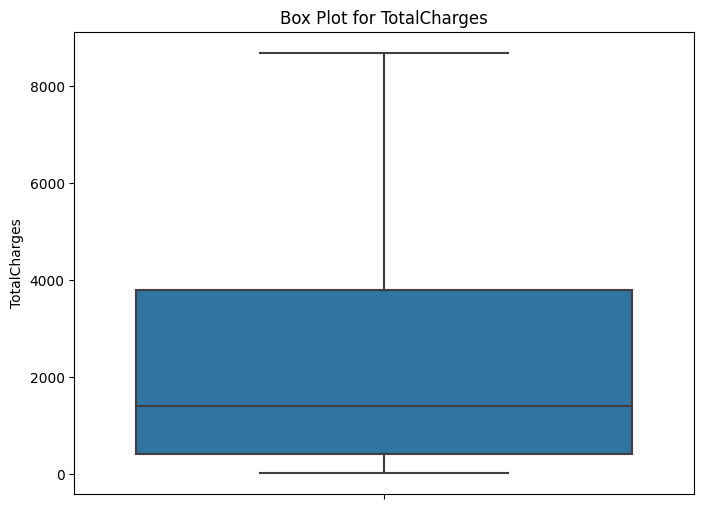

In [ ]:


# Set the size of the figure
plt.figure(figsize=(16, 8))

# Iterate through each numerical feature and create a box plot
for column in numerical_features.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=numerical_features[column])  # Use 'y' instead of 'x'
    plt.title(f'Box Plot for {column}')
    plt.show()

there aren't outliers

## Check for multicollinearity

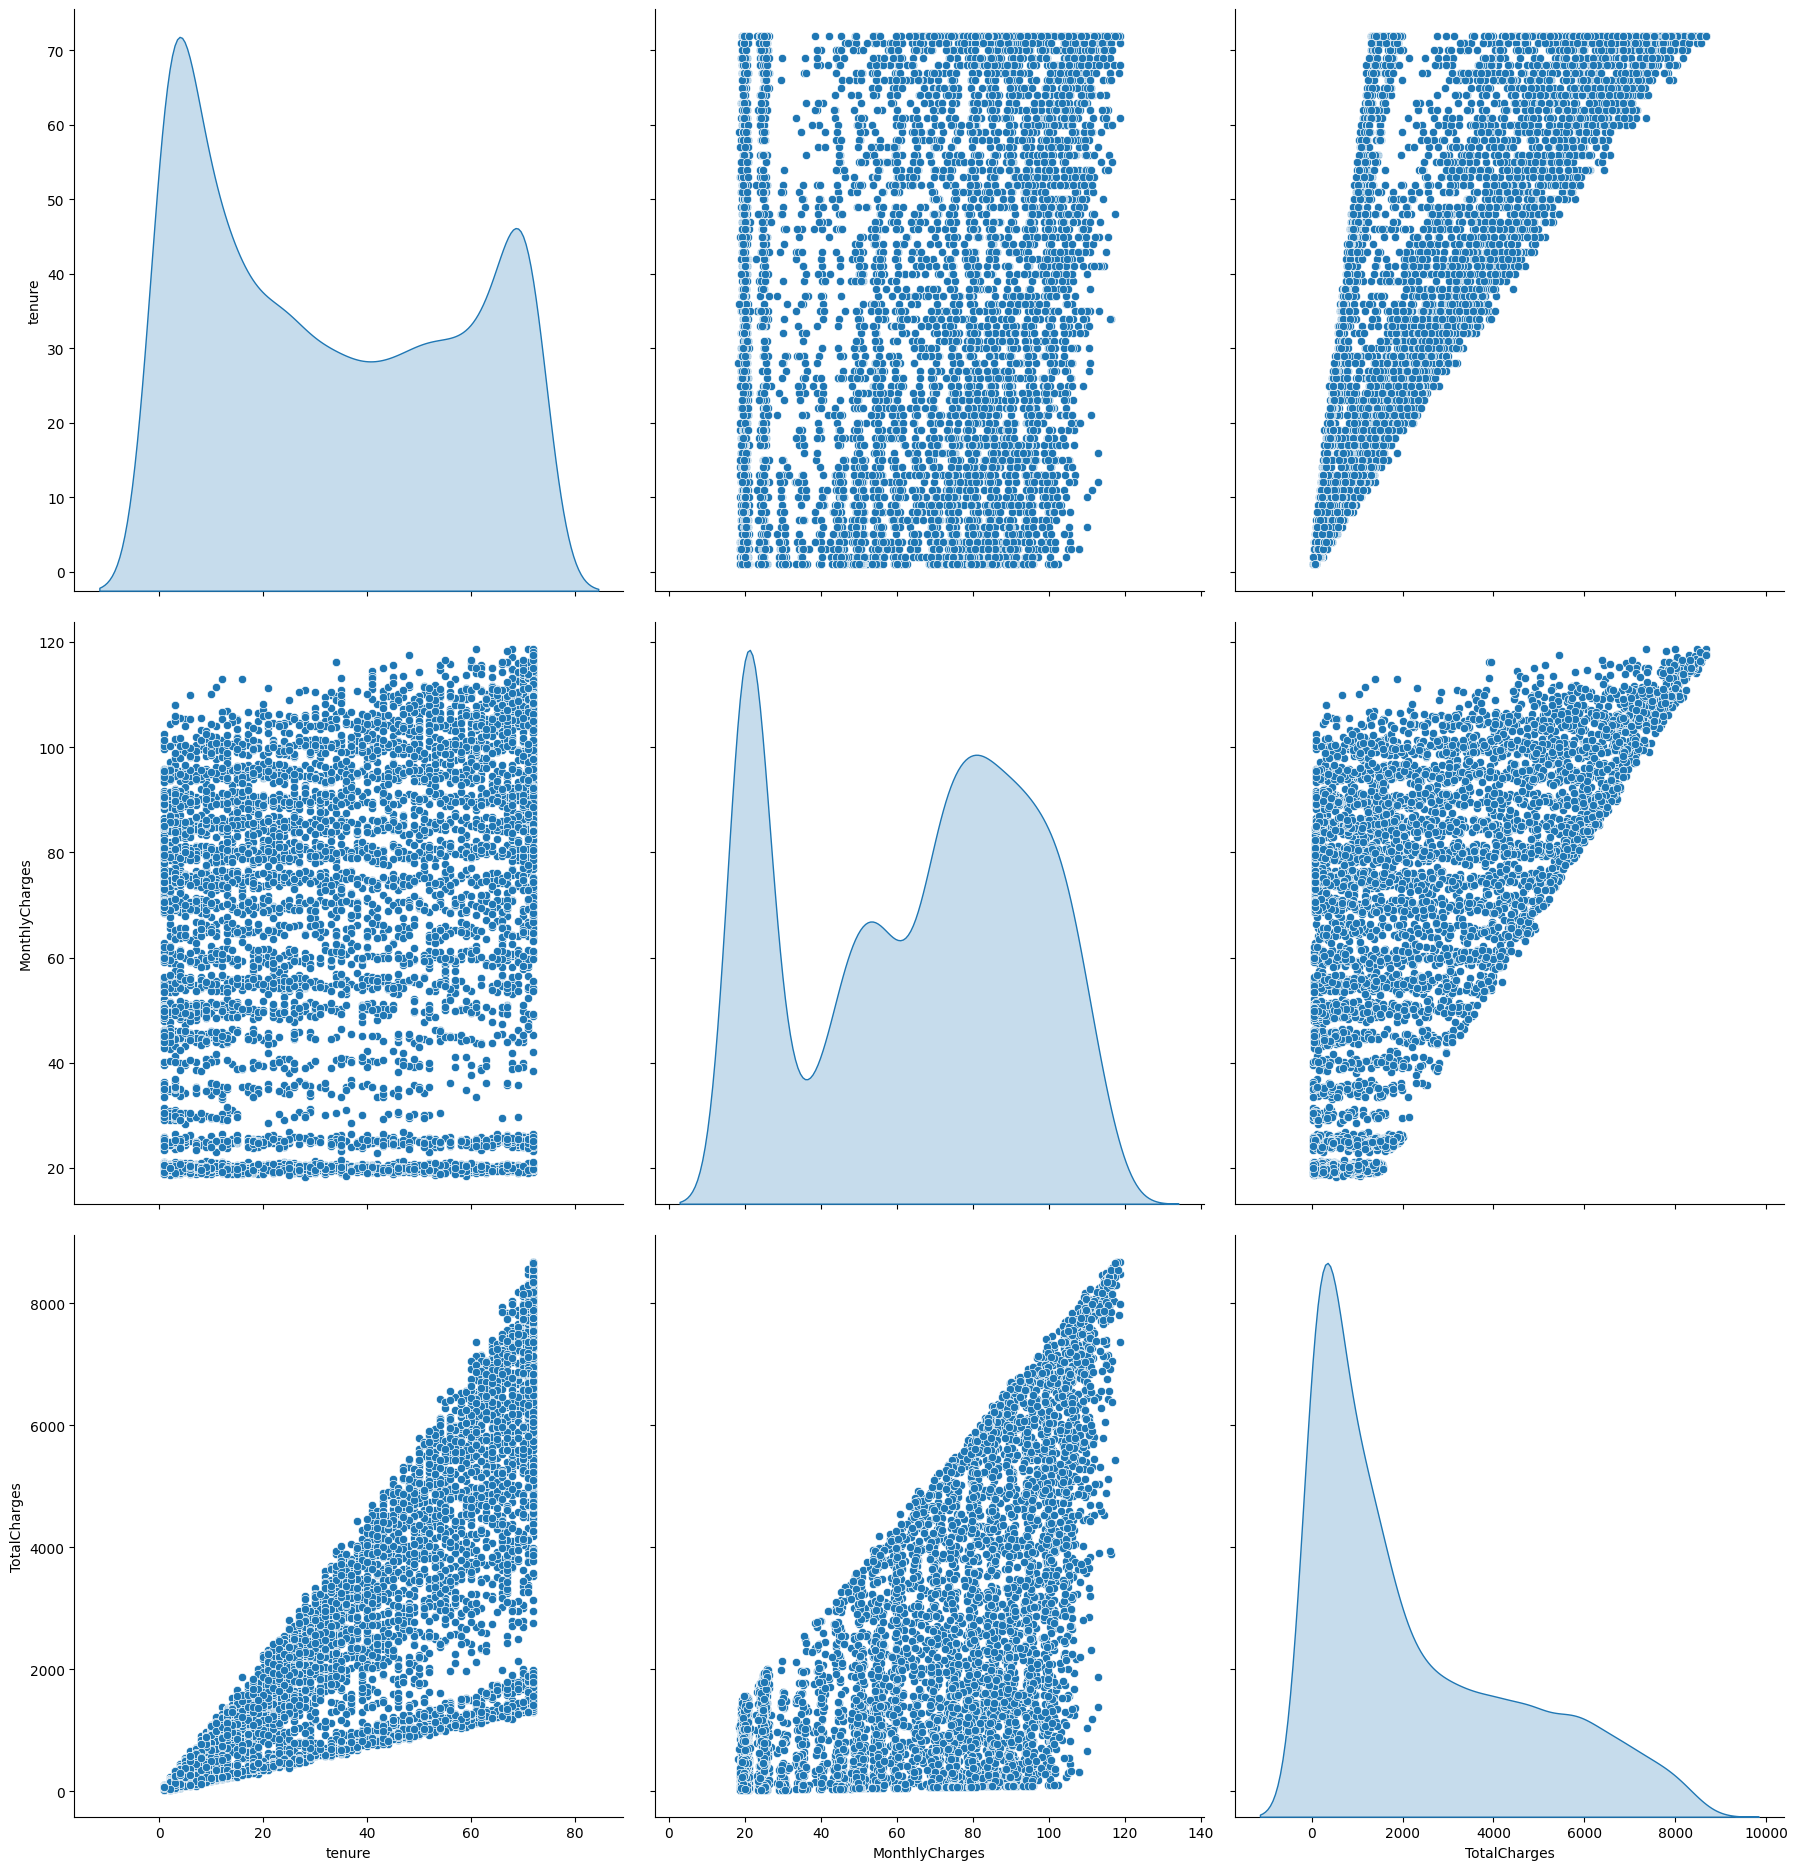

In [ ]:





#Check for multicollinearity using Scatter Matrix
scatter_matrix = sns.pairplot(numerical_features, diag_kind='kde', plot_kws={'alpha': 1})
scatter_matrix.fig.set_size_inches(20, 20)
plt.show()

In [ ]:

#handling the missing values in numric_fetures with mean
numerical_features.fillna(numerical_features.median(), inplace=True)
# Compute the VIF for each independent variable
vif = pd.DataFrame()
vif["variable"] = numerical_features.columns
vif["VIF"] = [variance_inflation_factor(numerical_features.values, i) for i in range(numerical_features.shape[1])]
# Select variables with high VIF
high_vif_variables = vif[vif["VIF"] > 10]["variable"]
print(high_vif_variables)

Series([], Name: variable, dtype: object)


there aren't multicollinearity

## Features Distributions

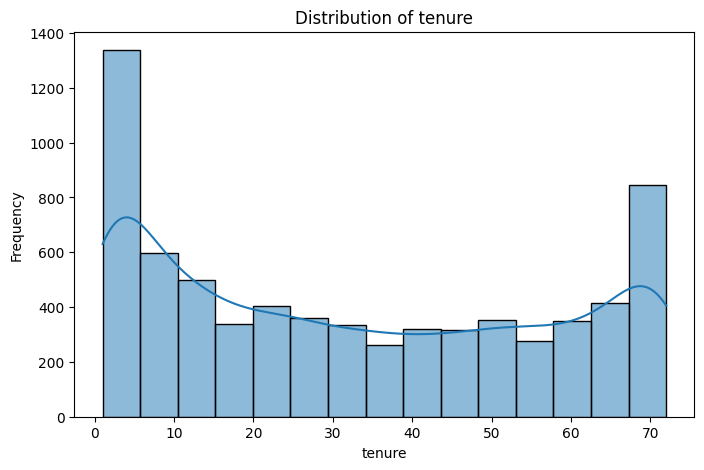

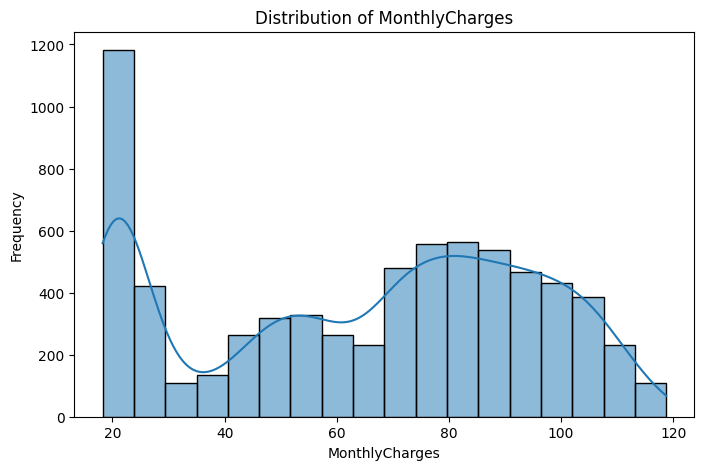

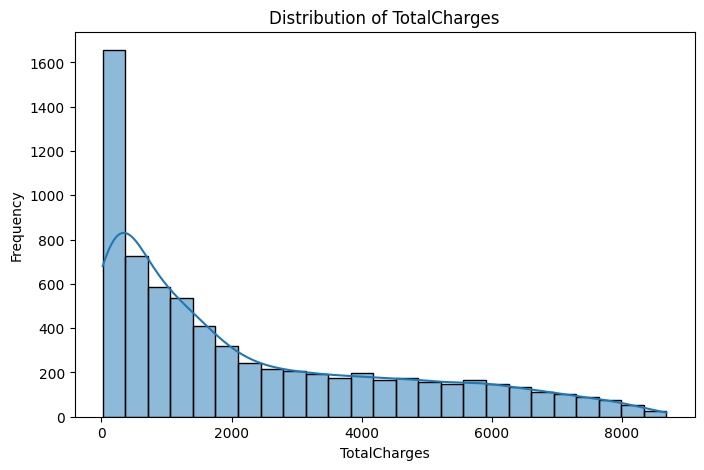

In [ ]:


# Assuming numerical_features is your DataFrame containing numerical features
for column in numerical_features.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=numerical_features[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.ylabel('Frequency')
    plt.show()



we note that the  distributions of the
 data are skewed

## Handling Skwed Data

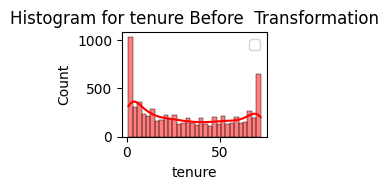

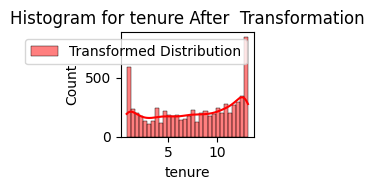

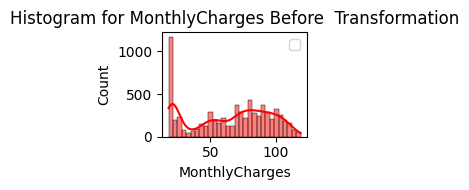

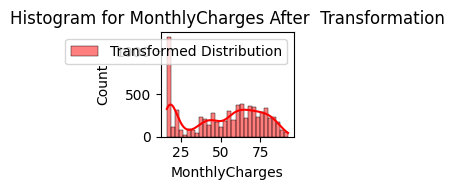

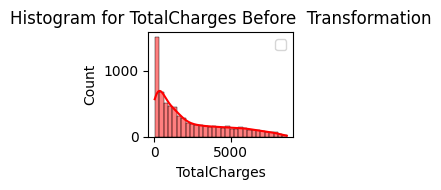

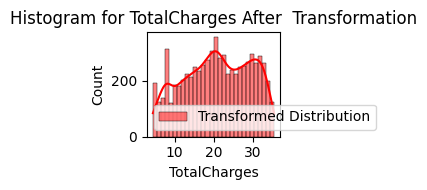

In [ ]:

# Loop through each numerical feature
for feature in numerical_features:

      # Plot histograms before and after transformation
    plt.figure(figsize=(4, 2))


    # Plot histogram after transformation
    plt.subplot(1, 2, 2)
    sns.histplot(data[feature], bins=30, kde=True, color='red')
    plt.title(f'Histogram for {feature} Before  Transformation')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Apply transformation
    transformed_feature, lambda_value = yeojohnson(data[feature])
    data[feature] = yeojohnson(data[feature], lmbda=lambda_value)


    # Plot histograms before and after transformation
    plt.figure(figsize=(4, 2))


    # Plot histogram after transformation
    plt.subplot(1, 2, 2)
    sns.histplot( data[feature], bins=30, kde=True, color='red', label='Transformed Distribution')
    plt.title(f'Histogram for {feature} After  Transformation')
    plt.legend()

    plt.tight_layout()
    plt.show()

# EDA and Preprocessing For Categorical Features

In [ ]:
#select the catgorical features only and drop target
categorical_features = data.select_dtypes(include=[object])

## Ensure From The Data Types

In [ ]:
#Ensure from the count of catgorical features
cat_columns = len(categorical_features.columns)
print(f"Number of columns in categorical_features: {cat_columns}")

Number of columns in categorical_features: 16


In [ ]:
head_categorical=categorical_features.head()

html_head_categorical = create_scrollable_table(head_categorical, 'head_categorical', 'Head of the categorical features')

# Display the HTML
display(HTML(html_head_categorical))

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic)
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check


In [ ]:
#the unique values of each numrical feature

def display_unique_values(dataframe):
    unique_values_html = ""
    for column in dataframe.columns:
        unique_values = dataframe[column].unique()
        unique_values_html += f"<h4>Unique values for {column}:</h4>"
        unique_values_html += "<div style='max-height: 200px; overflow-y: auto;'>"
        unique_values_html += "<ul>"
        for value in unique_values:
            unique_values_html += f"<li>{value}</li>"
        unique_values_html += "</ul>"
        unique_values_html += "</div>"

    display(HTML(unique_values_html))

# Call the function to display unique values
display_unique_values(categorical_features)

##  Summary statistics for categorical features

In [ ]:


cat_summary_stats = categorical_features.describe().T
html_categorical = create_scrollable_table(cat_summary_stats, 'categorical_features', 'Summary statistics for categorical features')

display(HTML(html_categorical ))

,count,unique,top,freq
gender,7010,2,Male,3535
SeniorCitizen,7010,2,0,5869
Partner,7010,2,No,3617
Dependents,7010,2,No,4911
PhoneService,7010,2,Yes,6330
MultipleLines,7010,3,No,3363
InternetService,7010,3,Fiber optic,3090
OnlineSecurity,7010,3,No,3489
OnlineBackup,7010,3,No,3079
DeviceProtection,7010,3,No,3086


## Chi_Squre Test

In [ ]:


# Assuming df is your DataFrame with categorical features and target variable
# Replace 'TargetColumn' with the actual name of your target column
target_column = 'Churn'
significance_level = 0.05

# Create a list to store results
results = []

# Create a contingency table for each pair of categorical feature and target variable
for column in categorical_features:
    if column != target_column:
        contingency_table = pd.crosstab(categorical_features[column], data[target_column])
        chi2, p, _, _ = chi2_contingency(contingency_table)

        significance = "Significant" if p < significance_level else "Not Significant"

        results.append([column, chi2, p, significance])

# Create a DataFrame from the results
result_df = pd.DataFrame(results, columns=["Feature", "Chi2 Statistic", "P-value", "Significance"])

# Print the tabulated results
print('chi_squre Test Between The Target Varaible (churn) And the Categorical Features :')
print(tabulate(result_df, headers='keys', tablefmt='pretty', showindex=False))


chi_squre Test Between The Target Varaible (churn) And the Categorical Features :
+------------------+--------------------+-------------------------+-----------------+
|     Feature      |   Chi2 Statistic   |         P-value         |  Significance   |
+------------------+--------------------+-------------------------+-----------------+
|      gender      | 0.491236602618337  |   0.4833762023458479    | Not Significant |
|  SeniorCitizen   | 159.4792982375864  | 1.4703357738516273e-36  |   Significant   |
|     Partner      | 154.26693117310947 | 2.0248561714739414e-35  |   Significant   |
|    Dependents    | 183.99998732389344 |  6.48802519091279e-42   |   Significant   |
|   PhoneService   | 0.7766911304348848 |   0.37815502389537725   | Not Significant |
|  MultipleLines   | 12.303285849890518 |  0.002129979497390785   |   Significant   |
| InternetService  |  728.444400823442  | 6.611624411865297e-159  |   Significant   |
|  OnlineSecurity  | 843.4654315552659  | 6.97924910754270

we note that gender and phoneservice are not significant with the target variable  and we can remove them from the data

In [ ]:
# Drop columns from the original DataFrame
data = data.drop(['gender', 'PhoneService'], axis=1)

# If 'categorical_features' is a DataFrame, drop columns from it as well
if 'categorical_features' in locals() or 'categorical_features' in globals():
    categorical_features = categorical_features.drop(['gender', 'PhoneService'], axis=1)


## Categorical Features Encoding

In [ ]:
categorical_features_without_senior = [col for col in categorical_features if col != 'SeniorCitizen']

# Apply one-hot encoding excluding 'SeniorCitizen'
data_encoded = pd.get_dummies(data[categorical_features_without_senior])

# Replace the original categorical columns with the one-hot encoded columns
data = pd.concat([data.drop(columns=categorical_features_without_senior), data_encoded], axis=1)

#ensure
head = data.head()
# create_scrollable_table is defined somewhere in your code
html_head = create_scrollable_table(head, 'head', 'Head of the dataset')

# Display the HTML table to show all features
display(HTML(html_head))

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0.813658,25.282057,5.470605,0,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,0,8.799049,46.419750,22.828303,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,0,1.421723,44.042197,9.031702,1,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,0,10.243525,35.101056,22.651231,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,0,1.421723,56.870471,10.185329,1,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0


# Feature engineering and selection

## Applying Filter Methods

### correlation analysis

In [ ]:


# Assuming 'df' is your DataFrame with encoded features
encoded_features = data.drop(['Churn'], axis=1)

# Calculate the correlation matrix
correlation_matrix = encoded_features.corr()

# Set a threshold for high correlation (adjust as needed)
threshold = 0.9

# Extract pairs of highly correlated features
high_correlation_pairs = (correlation_matrix.abs() > threshold) & (correlation_matrix < 1)

# Create a DataFrame for the result
high_correlation_table = pd.DataFrame(columns=['Feature 1', 'Feature 2', 'Correlation'])

for i in range(len(high_correlation_pairs.columns)):
    for j in range(i + 1, len(high_correlation_pairs.columns)):
        if high_correlation_pairs.iloc[i, j]:
            feature_1 = high_correlation_pairs.columns[i]
            feature_2 = high_correlation_pairs.index[j]
            correlation = correlation_matrix.loc[feature_1, feature_2]
            high_correlation_table = high_correlation_table.append({'Feature 1': feature_1,
                                                                    'Feature 2': feature_2,
                                                                    'Correlation': correlation},
                                                                    ignore_index=True)

# # Display the result
# print(high_correlation_table)


# create_scrollable_table is defined somewhere in your code
html_high_correlation_table = create_scrollable_table(high_correlation_table, 'high_correlation_table', 'high_correlation_table')

# Display the HTML table to show all features
display(HTML(html_high_correlation_table))


<ipython-input-437-4972298ad9ad>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = encoded_features.corr()
<ipython-input-437-4972298ad9ad>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  high_correlation_table = high_correlation_table.append({'Feature 1': feature_1,
<ipython-input-437-4972298ad9ad>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  high_correlation_table = high_correlation_table.append({'Feature 1': feature_1,
<ipython-input-437-4972298ad9ad>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  high_correlation_table =

,Feature 1,Feature 2,Correlation
0,tenure,TotalCharges,0.900064
1,Partner_No,Partner_Yes,-1.000000
2,Dependents_No,Dependents_Yes,-1.000000
3,PaperlessBilling_No,PaperlessBilling_Yes,-1.000000


In [ ]:
data.drop(['Partner_Yes', 'Dependents_Yes', 'PaperlessBilling_No','tenure'], axis=1, inplace=True)


- we will remove ['Partner_Yes', 'Dependents_Yes', 'PaperlessBilling_No','tenure'] from the data becuse they high correlated together
- we removed the non_significated features on step before

## Data Preparation

In [ ]:
data.columns

Index(['SeniorCitizen', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'Partner_No', 'Dependents_No', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)'

### seprate the data

In [ ]:
# Data Separation as X and Y
y= data['Churn']
x= data.drop('Churn',axis=1)

### split training set and test set

In [ ]:
print(y.value_counts())

0    5153
1    1857
Name: Churn, dtype: int64


In [ ]:
# Split the data into training set, validation set, and test set
x_train, x_val, y_train, y_val = train_test_split(x, y, stratify=y, train_size=0.7, random_state=0)
x_test, x_val, y_test, y_val = train_test_split(x_val, y_val, stratify=y_val, test_size=0.2, random_state=0)


### handling the imbalanced data

In [ ]:
print(y_train.value_counts())

0    3607
1    1300
Name: Churn, dtype: int64


In [ ]:
# Set the desired number of samples for each class
desired_samples = 3000

# Identify the classes you want to undersample
classes_to_undersample = [0]

# Calculate the current counts of instances in each class
class_counts = {cls: np.sum(y_train == cls) for cls in classes_to_undersample}

# Calculate the desired count for each class
desired_count = min(desired_samples, min(class_counts.values()))

# Calculate the sampling strategy for RandomUnderSampler
sampling_strategy = {cls: desired_count for cls in classes_to_undersample}

# Create a RandomUnderSampler object
under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)

# Apply undersampling to the training data
x_train, y_train = under_sampler.fit_resample(x_train, y_train)

print(y_train.value_counts())


0    3000
1    1300
Name: Churn, dtype: int64


In [ ]:
# Set the desired number of samples for each class
desired_samples = 2000

# Identify the classes you want to oversample
classes_to_oversample = [1]

# Calculate the current counts of instances in each class
class_counts = {cls: np.sum(y_train == cls) for cls in classes_to_oversample}

# Calculate the desired count for each class
desired_count = max(desired_samples, max(class_counts.values()))

# Calculate the sampling strategy for RandomoverSampler
sampling_strategy2 = {cls: desired_count for cls in classes_to_oversample}

# Create a RandomoverSampler object
SMOTE = SMOTE(sampling_strategy=sampling_strategy2, random_state=42)

# Apply oversampling to the training data
x_train, y_train =SMOTE.fit_resample(x_train, y_train)

print(y_train.value_counts())

0    3000
1    2000
Name: Churn, dtype: int64


### scale the data

In [ ]:
# Create the MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

# Fit and transform on training data
x_train = scaler.fit_transform(x_train)

# Transform on test data
x_test = scaler.fit_transform(x_test)

# Transform on test data
x_test = scaler.fit_transform(x_test)

# Transform on test data
x_val = scaler.fit_transform(x_val)

# Assuming x_train and x_test are NumPy arrays
cols = list(range(x_train.shape[1]))
# Convert the standardized NumPy arrays back to DataFrames
x_train = pd.DataFrame(x_train, columns=cols)
x_test = pd.DataFrame(x_test, columns=cols)

In [ ]:
print('Data:    ',data.shape)
print('----------------')
print('x train: ',x_train.shape)
print('y train: ',y_train.shape)
print('----------------')
print('x test:  ',x_test.shape)
print('y test:  ',y_test.shape)
print('----------------')
print('x val:  ',x_val.shape)
print('y val:  ',y_val.shape)

Data:     (7010, 38)
----------------
x train:  (5000, 37)
y train:  (5000,)
----------------
x test:   (1682, 37)
y test:   (1682,)
----------------
x val:   (421, 37)
y val:   (421,)


# Classification Models

## Logistic Regreission Model

In [ ]:
# Assuming x_train, y_train, x_test, y_test are defined

# Define Logistic Regression Model
lr_model = LogisticRegression()

# Set Up Parameter Grid
param_grid = {
    'penalty': ['l2', 'l1'],
    'C': [15.13908051025639, 0.01, 0.1],
    'solver': ['lbfgs', 'sag', 'saga'],
    'max_iter': [100, 50, 20],
    'multi_class': ['auto']
}

# Perform Grid Search
grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(x_train, y_train)


# Get Best Parameters and Model
best_params = grid_search.best_params_
best_lr_model = grid_search.best_estimator_

# Evaluate the model using cross-validation
cv_scores = cross_val_score (best_lr_model, x_train, y_train,cv=5, scoring='f1_weighted')
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Score:", np.mean(cv_scores))

# Print the best parameters found by GridSearchCV
print("Best Parameters:", best_params)

# Calculate F1 score on the test set
y_lr_pred_test = best_lr_model.predict(x_test)
f1_test = f1_score(y_test, y_lr_pred_test, average='weighted')
print("F1 Score on Test Set:", f1_test)

# Calculate F1 score on the train set
y_lr_pred_train = best_lr_model.predict(x_train)
f1_train = f1_score(y_train, y_lr_pred_train, average='weighted')
print("F1 Score on Train Set:", f1_train)

# Calculate F1 score on the val set
y_lr_pred_val = best_lr_model.predict(x_val)
f1_val = f1_score(y_val, y_lr_pred_val, average='weighted')
print("F1 Score on val Set:", f1_val)

# Evaluate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_lr_pred_test)
print("Test Accuracy:", test_accuracy)

# Evaluate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_lr_pred_train)
print("Train Accuracy:", train_accuracy)

# Evaluate accuracy on the val set
val_accuracy = accuracy_score(y_val, y_lr_pred_val)
print("val Accuracy:", val_accuracy)

# Classification Report
class_report_test = classification_report(y_test, y_lr_pred_test)
print("\nClassification Report (Test Set):")
print(class_report_test)

class_report_train = classification_report(y_train, y_lr_pred_train)
print("\nClassification Report (Train Set):")
print(class_report_train)


class_report_val = classification_report(y_val, y_lr_pred_val)
print("\nClassification Report (val Set):")
print(class_report_val)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Cross-Validation Scores: [0.75717692 0.75323973 0.76217175 0.86795051 0.8918471 ]
Average Cross-Validation Score: 0.8064772011999672
Best Parameters: {'C': 15.13908051025639, 'max_iter': 50, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'lbfgs'}
F1 Score on Test Set: 0.7968163249448191
F1 Score on Train Set: 0.812850651252657
F1 Score on val Set: 0.7822089621040904
Test Accuracy: 0.7966706302021404
Train Accuracy: 0.8136
val Accuracy: 0.7862232779097387

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1237
           1       0.62      0.62      0.62       445

    accuracy                           0.80      1682
   macro avg       0.74      0.74      0.74      1682
weighted avg       0.80      0.80      0.80      1682


Classification Report (Train Set):
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      3000
           1       0.78      0.

## SVM Model

In [ ]:


# Define Support Vector Machine (SVM) Model
svm_model = SVC()

# Set Up Parameter Grid
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 0.001, 0.15],
    'gamma': ['auto']
}

# Create GridSearchCV Object
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='f1', verbose=1)
grid_search.fit(x_train, y_train)

# Get Best Parameters and Model
best_params = grid_search.best_params_
best_svm_model = grid_search.best_estimator_

# Print the best parameters found by GridSearchCV
print("Best Parameters:", best_params)

# Evaluate the model using cross-validation
cv_scores = cross_val_score (best_svm_model, x_train, y_train,cv=5, scoring='f1_weighted')
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Score:", np.mean(cv_scores))

# Evaluate the model on the test set and train set using the best parameters
y_svm_pred_test = best_svm_model.predict(x_test)
y_svm_pred_train = best_svm_model.predict(x_train)
y_svm_pred_val=best_svm_model.predict(x_val)

# Calculate F1 score on the test set
f1_test = f1_score(y_test, y_svm_pred_test, average='weighted')
print("F1 Score on Test Set:", f1_test)

f1_train = f1_score(y_train, y_svm_pred_train, average='weighted')
print("F1 Score on Train Set:", f1_train)

# Calculate F1 score on the val set
y_svm_pred_val = best_svm_model.predict(x_val)
f1_val = f1_score(y_val, y_svm_pred_val, average='weighted')
print("F1 Score on val Set:", f1_val)

# Evaluate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_svm_pred_test)

# Evaluate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_svm_pred_train)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Evaluate accuracy on the val set
val_accuracy = accuracy_score(y_val,  y_svm_pred_val)
print("val Accuracy:", val_accuracy)

# Classification Report
class_report_test = classification_report(y_test, y_svm_pred_test)
print("\nClassification Report_test set:")
print(class_report_test)

class_report_train = classification_report(y_train,y_svm_pred_train)
print("\nClassification Report_train set:")
print(class_report_train)

class_report_val = classification_report(y_val, y_svm_pred_val)
print("\nClassification Report (val Set):")
print(class_report_val)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'C': 0.15, 'gamma': 'auto', 'kernel': 'linear'}
Cross-Validation Scores: [0.75126889 0.75621788 0.76157909 0.84025122 0.87806346]
Average Cross-Validation Score: 0.7974761091401407
F1 Score on Test Set: 0.7962948469196784
F1 Score on Train Set: 0.8079778925868076
F1 Score on val Set: 0.7760764595719771
Training Accuracy: 0.8082
Test Accuracy: 0.796076099881094
val Accuracy: 0.7767220902612827

Classification Report_test set:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1237
           1       0.61      0.62      0.62       445

    accuracy                           0.80      1682
   macro avg       0.74      0.74      0.74      1682
weighted avg       0.80      0.80      0.80      1682


Classification Report_train set:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3000
           1       0.76

## Naive Model

In [ ]:

# Set up parameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]
}

# Create Multinomial Naive Bayes model
nb_model = MultinomialNB()

# Create GridSearchCV object
grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_nb_model = grid_search.best_estimator_

# Print the best parameters found by GridSearchCV
print("Best Parameters:", best_params)

# Evaluate the model using cross-validation
cv_scores = cross_val_score (best_nb_model, x_train, y_train,cv=5, scoring='f1_weighted')
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Score:", np.mean(cv_scores))

# Evaluate the model on the test set and train set using the best parameters
y_nb_pred_train = best_nb_model.predict(x_train)
y_nb_pred_test = best_nb_model.predict(x_test)
y_nb_pred_val=best_nb_model.predict(x_val)

# Calculate F1 score on the test set
f1_test = f1_score(y_test, y_nb_pred_test, average='weighted')
print("F1 Score on Test Set:", f1_test)

f1_train = f1_score(y_train, y_nb_pred_train, average='weighted')
print("F1 Score on Train Set:", f1_train)

# Calculate F1 score on the val set
y_svm_pred_val = best_nb_model.predict(x_val)
f1_val = f1_score(y_val, y_nb_pred_val, average='weighted')
print("F1 Score on val Set:", f1_val)

# Evaluate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_nb_pred_test)
print(f"Test Accuracy: {test_accuracy}")

# Evaluate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_nb_pred_train)
print(f"Training Accuracy: {train_accuracy}")

# Evaluate accuracy on the val set
val_accuracy = accuracy_score(y_val,  y_nb_pred_val)
print("val Accuracy:", val_accuracy)

# Classification Report
class_report_test = classification_report(y_test, y_nb_pred_test)
print("\nClassification Report_test set:")
print(class_report_test)

class_report_train = classification_report(y_train,y_nb_pred_train)
print("\nClassification Report_train set:")
print(class_report_train)

class_report_val = classification_report(y_val, y_nb_pred_val)
print("\nClassification Report (val Set):")
print(class_report_val)




Best Parameters: {'alpha': 0.1}
Cross-Validation Scores: [0.72391189 0.72853834 0.7212979  0.73248408 0.75569182]
Average Cross-Validation Score: 0.7323848055163278
F1 Score on Test Set: 0.7334985650973607
F1 Score on Train Set: 0.7337669246700705
F1 Score on val Set: 0.7180966472140806
Test Accuracy: 0.7170035671819263
Training Accuracy: 0.7318
val Accuracy: 0.7007125890736342

Classification Report_test set:
              precision    recall  f1-score   support

           0       0.92      0.67      0.78      1237
           1       0.48      0.84      0.61       445

    accuracy                           0.72      1682
   macro avg       0.70      0.76      0.69      1682
weighted avg       0.80      0.72      0.73      1682


Classification Report_train set:
              precision    recall  f1-score   support

           0       0.87      0.65      0.74      3000
           1       0.62      0.85      0.72      2000

    accuracy                           0.73      5000
   macr

## KNN Model

In [ ]:
# Define the KNN model
knn_model = KNeighborsClassifier()

# Define the parameter grid
param_grid ={'leaf_size': range(1,20),
        'p': [1,2],
        'n_neighbors': range(1,21,3)}

# Create GridSearchCV Object
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='f1', verbose=1)
grid_search.fit(x_train, y_train)

# Get Best Parameters and Model
best_params = grid_search.best_params_
best_knn_model = grid_search.best_estimator_

# Print the best parameters found by GridSearchCV
print("Best Parameters:", best_params)

# Evaluate the model using cross-validation
cv_scores = cross_val_score (best_knn_model, x_train, y_train,cv=5, scoring='f1_weighted')
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Score:", np.mean(cv_scores))

# Evaluate the model using cross-validation
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=5, scoring=f'f1')
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Score:", np.mean(cv_scores))

# Evaluate the model on the test set and train set using the best parameters
y_knn_pred_test = best_knn_model.predict(x_test)
y_knn_pred_train = best_knn_model.predict(x_train)
y_knn_pred_val=best_knn_model.predict(x_val)


# Calculate F1 score
f1_test = f1_score(y_test, y_knn_pred_test, average='weighted')
print("F1 Score on Test Set:", f1_test)

f1_train = f1_score(y_train, y_knn_pred_train, average='weighted')
print("F1 Score on Train Set:", f1_train)

y_knn_pred_val = best_knn_model.predict(x_val)
f1_val = f1_score(y_val, y_knn_pred_val, average='weighted')
print("F1 Score on val Set:", f1_val)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_knn_pred_test)
print(f"Training Accuracy: {train_accuracy}")

train_accuracy = accuracy_score(y_train, y_knn_pred_train)
print(f"Test Accuracy: {test_accuracy}")

val_accuracy = accuracy_score(y_val,  y_knn_pred_val)
print("val Accuracy:", val_accuracy)


# Classification Report
class_report_test = classification_report(y_test, y_knn_pred_test)
print("\nClassification Report_test set:")
print(class_report_test)

class_report_train = classification_report(y_train,y_knn_pred_train)
print("\nClassification Report_train set:")
print(class_report_train)

class_report_val = classification_report(y_val, y_knn_pred_val)
print("\nClassification Report (val Set):")
print(class_report_val)

Fitting 5 folds for each of 266 candidates, totalling 1330 fits
Best Parameters: {'leaf_size': 1, 'n_neighbors': 13, 'p': 1}
Cross-Validation Scores: [0.74266954 0.75322761 0.73960207 0.81366719 0.80893043]
Average Cross-Validation Score: 0.7716193680702176
Cross-Validation Scores: [0.69129917 0.6870229  0.66666667 0.78240741 0.78290214]
Average Cross-Validation Score: 0.72205965554874
F1 Score on Test Set: 0.7536161124758818
F1 Score on Train Set: 0.8105905613087061
F1 Score on val Set: 0.7687685356526873
Training Accuracy: 0.7318
Test Accuracy: 0.7455410225921522
val Accuracy: 0.7648456057007126

Classification Report_test set:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      1237
           1       0.52      0.64      0.57       445

    accuracy                           0.75      1682
   macro avg       0.69      0.71      0.70      1682
weighted avg       0.77      0.75      0.75      1682


Classification Report_train set:
 

## DecisionTree Model

In [ ]:
# Define the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 10),
    'min_samples_split': np.arange(1, 5),
    'min_samples_leaf':np.arange(1,5)
}

# Use F1 score as the scoring metric for GridSearchCV
f1_scorer = make_scorer(f1_score, average='weighted')

# Perform GridSearchCV
grid_search = GridSearchCV(dt_model, param_grid, scoring=f1_scorer, cv=5)
grid_search.fit(x_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=5, scoring=f1_scorer)
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Score:", np.mean(cv_scores))

#calculate_(f1_score)
# Evaluate the model on the test set and train test using the best parameters
best_dt_model = grid_search.best_estimator_
y_dt_pred_test = best_dt_model.predict(x_test)
y_dt_pred_train= best_dt_model.predict(x_train)
y_dt_pred_val=best_dt_model.predict(x_val)

# Calculate F1 score on the test set
f1_test = f1_score(y_test, y_dt_pred_test, average='weighted')
print("F1 Score on Test Set:", f1_test)
f1_train = f1_score(y_train, y_dt_pred_train, average='weighted')
print("F1 Score on train Set:", f1_train)

# Calculate F1 score on the val set
y_dt_pred_val = best_dt_model.predict(x_val)
f1_val = f1_score(y_val, y_dt_pred_val, average='weighted')
print("F1 Score on val Set:", f1_val)


#calculate_accurcy
# Evaluate on the test set
test_accuracy = accuracy_score(y_test, y_dt_pred_test)

# Evaluate on the training set
train_accuracy = accuracy_score(y_train, y_dt_pred_train)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Evaluate accuracy on the val set
val_accuracy = accuracy_score(y_val,  y_dt_pred_val)
print("val Accuracy:", val_accuracy)

# Classification Report
class_report_test = classification_report(y_test, y_dt_pred_test)

class_report_train = classification_report(y_train,y_dt_pred_train)

print("\nClassification Report_test set:")
print(class_report_test)


print("\nClassification Report_train set:")
print(class_report_train)

class_report_val = classification_report(y_val, y_dt_pred_val)
print("\nClassification Report (val Set):")
print(class_report_val)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
320 fits failed out of a total of 1280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _val

Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Cross-Validation Scores: [0.73766182 0.75254271 0.76308936 0.7989579  0.84079405]
Average Cross-Validation Score: 0.7786091662925344
F1 Score on Test Set: 0.7853635066511638
F1 Score on train Set: 0.786713966314006
F1 Score on val Set: 0.7670615128036669
Training Accuracy: 0.7866
Test Accuracy: 0.7806183115338883
val Accuracy: 0.7648456057007126

Classification Report_test set:
              precision    recall  f1-score   support

           0       0.87      0.82      0.85      1237
           1       0.57      0.66      0.62       445

    accuracy                           0.78      1682
   macro avg       0.72      0.74      0.73      1682
weighted avg       0.79      0.78      0.79      1682


Classification Report_train set:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      3000
           1       0.73      0.74      0.73 

## RandomForest

In [ ]:
# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [250,100,50],
    'max_depth': [5, 1, 2],
    'min_samples_split': [10,8,5],
    'min_samples_leaf': [1, 2,3],
    'max_features': ['sqrt', 'auto', None],
    'bootstrap': [True, False]
 }

# Use F1 score as the scoring metric for GridSearchCV
f1_scorer = make_scorer(f1_score, average='weighted')

# Perform GridSearchCV
grid_search = GridSearchCV(rf_model, param_grid, scoring=f1_scorer, cv=5)
grid_search.fit(x_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=5, scoring=f1_scorer)
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Score:", np.mean(cv_scores))

# #calculate_(f1_score)
# # Evaluate the model on the test set and train test using the best parameters
best_rf_model = grid_search.best_estimator_

y_rf_pred_test = best_rf_model.predict(x_test)
y_rf_pred_train= best_rf_model.predict(x_train)
y_rf_pred_val=best_rf_model.predict(x_val)

# Calculate F1 score on the test set
f1_test = f1_score(y_test, y_rf_pred_test, average='weighted')
print("F1 Score on Test Set:", f1_test)
f1_train = f1_score(y_train, y_rf_pred_train, average='weighted')
print("F1 Score on train Set:", f1_train)

# Calculate F1 score on the val set
y_rf_pred_val = best_rf_model.predict(x_val)
f1_val = f1_score(y_val, y_rf_pred_val, average='weighted')
print("F1 Score on val Set:", f1_val)

#calculate_accurcy
# Evaluate on the test set
test_accuracy = accuracy_score(y_test, y_rf_pred_test)

# Evaluate on the training set
train_accuracy = accuracy_score(y_train, y_rf_pred_train)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

val_accuracy = accuracy_score(y_val,  y_rf_pred_val)
print("val Accuracy:", val_accuracy)

# Classification Report
class_report_test = classification_report(y_test, y_rf_pred_test)

class_report_train = classification_report(y_train,y_rf_pred_train)

print("\nClassification Report_test set:")
print(class_report_test)


print("\nClassification Report_train set:")
print(class_report_train)

class_report_val = classification_report(y_val, y_rf_pred_val)
print("\nClassification Report (val Set):")
print(class_report_val)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best Parameters: {'bootstrap': True, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 250}
Cross-Validation Scores: [0.75020859 0.76231256 0.76654171 0.80792932 0.8461736 ]
Average Cross-Validation Score: 0.786633156134815
F1 Score on Test Set: 0.7882863052330557
F1 Score on train Set: 0.7995220401422765
F1 Score on val Set: 0.7734398783667745
Training Accuracy: 0.7988
Test Accuracy: 0.7824019024970273
val Accuracy: 0.7695961995249406

Classification Report_test set:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1237
           1       0.57      0.69      0.63       445

    accuracy                           0.78      1682
   macro avg       0.73      0.75      0.74      1682
weighted avg       0.80      0.78      0.79      1682


Classification Report_train set:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      3000
     

## GradientBoosting Model

In [ ]:
# Define the Random Forest model
gb_model = GradientBoostingClassifier()

# Define the parameter grid for GridSearchCV
# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.001],
    'n_estimators': [250, 100,50],
    'subsample': [0.5, 1.0],
    'min_samples_split': [ 10, 100,50],
    'min_samples_leaf': [ 2, 1],
    'max_depth': [ 2,3,5],

}

# Use F1 score as the scoring metric for GridSearchCV
f1_scorer = make_scorer(f1_score, average='weighted')

# Perform GridSearchCV
grid_search = GridSearchCV(gb_model, param_grid, scoring=f1_scorer, cv=5)
grid_search.fit(x_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=5, scoring=f1_scorer)
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Score:", np.mean(cv_scores))

# #calculate_(f1_score)
# # Evaluate the model on the test set and train test using the best parameters
best_gb_model = grid_search.best_estimator_

y_gb_pred_test = best_gb_model.predict(x_test)
y_gb_pred_train= best_gb_model.predict(x_train)
y_gb_pred_val=best_gb_model.predict(x_val)

# Calculate F1 score on the test set
f1_test = f1_score(y_test, y_gb_pred_test, average='weighted')
print("F1 Score on Test Set:", f1_test)
f1_train = f1_score(y_train, y_gb_pred_train, average='weighted')
print("F1 Score on train Set:", f1_train)

# Calculate F1 score on the val set
y_gb_pred_val = best_gb_model.predict(x_val)
f1_val = f1_score(y_val, y_gb_pred_val, average='weighted')
print("F1 Score on val Set:", f1_val)


#calculate_accurcy
# Evaluate on the test set
test_accuracy = accuracy_score(y_test, y_gb_pred_test)

# Evaluate on the training set
train_accuracy = accuracy_score(y_train, y_gb_pred_train)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Evaluate accuracy on the val set
val_accuracy = accuracy_score(y_val,  y_gb_pred_val)
print("val Accuracy:", val_accuracy)

# Classification Report
class_report_test = classification_report(y_test, y_gb_pred_test)

class_report_train = classification_report(y_train,y_gb_pred_train)

print("\nClassification Report_test set:")
print(class_report_test)

print("\nClassification Report_train set:")
print(class_report_train)

class_report_val = classification_report(y_val, y_gb_pred_val)
print("\nClassification Report (val Set):")
print(class_report_val)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 100, 'n_estimators': 250, 'subsample': 0.5}
Cross-Validation Scores: [0.7546291  0.7656907  0.76173746 0.83283375 0.87580576]
Average Cross-Validation Score: 0.798139353908817
F1 Score on Test Set: 0.7970308518375175
F1 Score on train Set: 0.82469367240617
F1 Score on val Set: 0.7787805249021239
Training Accuracy: 0.8246
Test Accuracy: 0.7954815695600476
val Accuracy: 0.7790973871733967

Classification Report_test set:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1237
           1       0.61      0.64      0.62       445

    accuracy                           0.80      1682
   macro avg       0.74      0.75      0.74      1682
weighted avg       0.80      0.80      0.80      1682


Classification Report_train set:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      3000
      

## XGBoosting Model

In [ ]:
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Assuming X_train and y_train are your training data
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 25, 100),
        'subsample': trial.suggest_uniform('subsample', 0 ,1),
        'min_child_weight': trial.suggest_uniform('min_child_weight', 0.5, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.2, 0.8),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'objective': 'binary:logistic',  # Assuming it's a binary classification problem
        'eval_metric': 'logloss',
        'random_state': 0
    }

    # Create the XGBoost model with suggested hyperparameters
    xgb_model = xgb.XGBClassifier(**params)

    # Evaluate the model using cross-validation
    score = cross_val_score(xgb_model, x_train, y_train, cv=5, scoring='roc_auc').mean()

    return score

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best parameters found by Optuna
print("Best Parameters:", study.best_params)


[I 2023-12-20 22:23:07,560] A new study created in memory with name: no-name-3c393b96-600f-4b6b-893d-03bf59355b9e
<ipython-input-528-8670c49ea4d6>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-528-8670c49ea4d6>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0 ,1),
<ipython-input-528-8670c49ea4d6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'min_child_weight': trial.suggest_uniform('min_child_weight', 0.

Best Parameters: {'learning_rate': 0.0404186318262054, 'n_estimators': 91, 'subsample': 0.8735018206765689, 'min_child_weight': 0.9676109401198187, 'colsample_bytree': 0.7707223168121946, 'max_depth': 8}


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report

# Assuming x_train, y_train, x_test, y_test, x_val, y_val are defined

# Create an XGBClassifier instance
xg_model = XGBClassifier(
    n_estimators=91,
    learning_rate=0.0404186318262054,
    max_depth=6,
    min_child_weight=0.9676109401198187,
    subsample=0.8743799880998639,
    colsample_bytree= 0.7707223168121946,
    random_state=42,
    reg_alpha=0.1,  # Updated from alpha to reg_alpha
    reg_lambda=1    # Updated from lambda to reg_lambda
)

# Train the model
xg_model.fit(x_train, y_train, eval_metric="logloss", eval_set=[(x_val, y_val)], early_stopping_rounds=10)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(xg_model, x_train, y_train, cv=5, scoring='f1_weighted')
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Score:", np.mean(cv_scores))

# Predictions
y_xg_pred_test = xg_model.predict(x_test)
y_xg_pred_train = xg_model.predict(x_train)
y_xg_pred_val = xg_model.predict(x_val)

# Calculate F1 score on the test set
f1_test = f1_score(y_test, y_xg_pred_test, average='weighted')
print("F1 Score on Test Set:", f1_test)

# Calculate F1 score on the train set
f1_train = f1_score(y_train, y_xg_pred_train, average='weighted')
print("F1 Score on Train Set:", f1_train)

# Calculate F1 score on the val set
f1_val = f1_score(y_val, y_xg_pred_val, average='weighted')
print("F1 Score on Val Set:", f1_val)

# Calculate accuracy
# Evaluate on the test set
test_accuracy = accuracy_score(y_test, y_xg_pred_test)

# Evaluate on the training set
train_accuracy = accuracy_score(y_train, y_xg_pred_train)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Evaluate accuracy on the val set
val_accuracy = accuracy_score(y_val, y_xg_pred_val)
print("Val Accuracy:", val_accuracy)

# Classification Report
class_report_test = classification_report(y_test, y_xg_pred_test)
class_report_train = classification_report(y_train, y_xg_pred_train)
class_report_val = classification_report(y_val, y_xg_pred_val)

print("\nClassification Report (Test Set):")
print(class_report_test)

print("\nClassification Report (Train Set):")
print(class_report_train)

print("\nClassification Report (Val Set):")
print(class_report_val)






/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.60817
[1]	validation_0-logloss:0.59697
[2]	validation_0-logloss:0.58674
[3]	validation_0-logloss:0.57812
[4]	validation_0-logloss:0.56984
[5]	validation_0-logloss:0.56186
[6]	validation_0-logloss:0.55343
[7]	validation_0-logloss:0.54604
[8]	validation_0-logloss:0.53969
[9]	validation_0-logloss:0.53392
[10]	validation_0-logloss:0.52798
[11]	validation_0-logloss:0.52251
[12]	validation_0-logloss:0.51809
[13]	validation_0-logloss:0.51320
[14]	validation_0-logloss:0.50882
[15]	validation_0-logloss:0.50382
[16]	validation_0-logloss:0.49909
[17]	validation_0-logloss:0.49511
[18]	validation_0-logloss:0.49150
[19]	validation_0-logloss:0.48806
[20]	validation_0-logloss:0.48494
[21]	validation_0-logloss:0.48184
[22]	validation_0-logloss:0.47855
[23]	validation_0-logloss:0.47620
[24]	validation_0-logloss:0.47369
[25]	validation_0-logloss:0.47097
[26]	validation_0-logloss:0.46913
[27]	validation_0-logloss:0.46704
[28]	validation_0-logloss:0.46528
[29]	validation_0-loglos

# Choose The Best Model

from these outputs, I will choose the SVM model as the best model to predict this data, because it has the lowest difference between the train and test sets' accuracy